# Login

In [1]:
from prediction import jwt_access

url = "https://server.ecosystem.ai:3001/api"
username = "user@ecosystem.ai"
password = "12345"
auth = jwt_access.Authenticate(url, username, password)

Login Successful.


# Multivariate

## Ingest Data

In [2]:
from prediction.apis import data_management_engine
from prediction.apis import data_ingestion_engine
from prediction.apis import data_munging_engine
from prediction.apis import worker_h2o
from prediction.apis import prediction_engine
from prediction import prediction_utils

import pandas as pd
import matplotlib.pyplot as plt
import json
import threading

In [3]:
db_name = "multivariate_testcase"

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/sagarmk/Forecasting-on-Air-pollution-with-RNN-LSTM/master/pollution.csv',index_col=0)
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


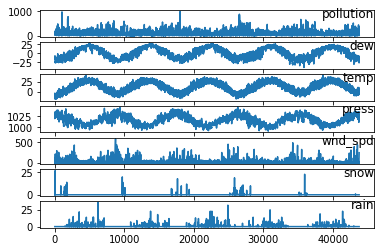

In [5]:
# specify columns to plot
values = df.values
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

## Enrich

In [6]:
df2 = df.copy()
num_lags = 3 # number of lags and window lenghts for mean aggregation
delay = 1 # predict target one step ahead
for column in df2:
    for lag in range(1,num_lags+1):
        df2[column + '_lag' + str(lag)] = df2[column].shift(lag*-1-(delay-1))
        if column != 'wnd_dir':
            df2[column + '_avg_window_length' + str(lag+1)] = df2[column].shift(-1-(delay-1)).rolling(window=lag+1,center=False).mean().shift(1-(lag+1))

df2.dropna(inplace=True) 

mask = (df2.columns.str.contains('pollution') | df2.columns.str.contains('lag') | df2.columns.str.contains('window'))
df_processed = df2[df2.columns[mask]]

# the columns in the processed dataframe
df_processed.columns

Index(['pollution', 'pollution_lag1', 'pollution_avg_window_length2',
       'pollution_lag2', 'pollution_avg_window_length3', 'pollution_lag3',
       'pollution_avg_window_length4', 'dew_lag1', 'dew_avg_window_length2',
       'dew_lag2', 'dew_avg_window_length3', 'dew_lag3',
       'dew_avg_window_length4', 'temp_lag1', 'temp_avg_window_length2',
       'temp_lag2', 'temp_avg_window_length3', 'temp_lag3',
       'temp_avg_window_length4', 'press_lag1', 'press_avg_window_length2',
       'press_lag2', 'press_avg_window_length3', 'press_lag3',
       'press_avg_window_length4', 'wnd_dir_lag1', 'wnd_dir_lag2',
       'wnd_dir_lag3', 'wnd_spd_lag1', 'wnd_spd_avg_window_length2',
       'wnd_spd_lag2', 'wnd_spd_avg_window_length3', 'wnd_spd_lag3',
       'wnd_spd_avg_window_length4', 'snow_lag1', 'snow_avg_window_length2',
       'snow_lag2', 'snow_avg_window_length3', 'snow_lag3',
       'snow_avg_window_length4', 'rain_lag1', 'rain_avg_window_length2',
       'rain_lag2', 'rain_avg_win

In [7]:
mask = df_processed.columns.str.contains('pollution')
df_processed[df_processed.columns[mask]].head(10)

,pollution,pollution_lag1,pollution_avg_window_length2,pollution_lag2,pollution_avg_window_length3,pollution_lag3,pollution_avg_window_length4
date,,,,,,,
2010-01-02 00:00:00,129.0,148.0,153.5,159.0,162.666667,181.0,156.50
2010-01-02 01:00:00,148.0,159.0,170.0,181.0,159.333333,138.0,146.75
2010-01-02 02:00:00,159.0,181.0,159.5,138.0,142.666667,109.0,133.25
2010-01-02 03:00:00,181.0,138.0,123.5,109.0,117.333333,105.0,119.00
2010-01-02 04:00:00,138.0,109.0,107.0,105.0,112.666667,124.0,114.50
2010-01-02 05:00:00,109.0,105.0,114.5,124.0,116.333333,120.0,120.25
2010-01-02 06:00:00,105.0,124.0,122.0,120.0,125.333333,132.0,129.00
2010-01-02 07:00:00,124.0,120.0,126.0,132.0,130.666667,140.0,136.00
2010-01-02 08:00:00,120.0,132.0,136.0,140.0,141.333333,152.0,143.00


In [8]:
df_processed.reset_index(drop=True,inplace=True)
df_train = df_processed.loc[:int(df_processed.shape[0]*0.8),:]
df_test = df_processed.loc[int(df_processed.shape[0]*0.8):,:]

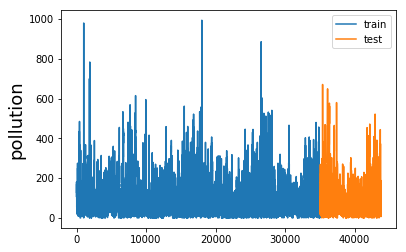

In [9]:
plt.plot(df_train.index,df_train['pollution'])
plt.plot(df_test.index,df_test['pollution'])
plt.ylabel('pollution',fontsize=18)
plt.legend(['train','test'])
plt.show()

In [22]:
result = data_management_engine.add_document_database(auth, "multivariate_testcase6")
print(result)

get /addMongoDatabase?database=multivariate_testcase6&
{'message': 'Success'}


In [23]:
col_name = "pollution_train"
result = data_management_engine.add_document_collection(auth, "multivariate_testcase6", col_name)
print(result)

col_name = "pollution_test"
result = data_management_engine.add_document_collection(auth, "multivariate_testcase6", col_name)
print(result)

get /addMongoCollection?database=multivariate_testcase6&collection=pollution_train&
{'message': 'Success'}
get /addMongoCollection?database=multivariate_testcase6&collection=pollution_test&
{'message': 'Success'}


In [16]:
import copy
import concurrent.futures

# training_data = list(df_train.T.to_dict().values())
# testing_data = list(df_test.T.to_dict().values())

db_name = "multivariate_testcase6"
col_name = "pollution_train"

j_dc_doc = {
    "database": db_name,
    "collection": col_name,
    "document": {}
}

def async_thread(auth, j_dc_doc, count, total):
    while True:
        try:
            data_management_engine.add_documents(auth, j_dc_doc, info=False)
            print("{}/{}".format(count, total))
            break
        except:
#             print("Error uploading: Retry")
            pass
    
with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
    count = 0
    for d in training_data:
        count += 1
        if count >= 1000:
            break
        j_dc_doc["document"] = dict(d)
        d2 = copy.deepcopy(j_dc_doc)
        executor.submit(async_thread, auth, d2, count, len(training_data))
            
# db_name = "multivariate_testcase6"
# col_name = "pollution_test"

# j_dc_doc = {
#     "database": db_name,
#     "collection": col_name,
#     "document": {}
# }

# with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
#     count = 0
#     for d in training_data:
#         count += 1
#         if count >= 5:
#             break
#         j_dc_doc["document"] = dict(d)
#         d2 = copy.deepcopy(j_dc_doc)
#         executor.submit(async_thread, auth, d2)
            


6/350373/35037

15/35037
10/35037
13/3503716/35037

2/35037
5/35037
1/35037
17/3503711/35037

7/35037
4/35037
9/35037
8/35037
14/35037
12/35037
18/3503727/35037

19/3503722/35037

21/3503720/3503726/35037


23/3503725/35037

24/35037
29/35037
37/3503730/35037

33/35037
36/35037
44/35037
34/3503743/35037

42/35037
38/35037
39/35037
41/35037
31/35037
48/35037
35/35037
32/35037
49/35037
40/35037
45/3503747/35037

50/35037
51/35037
46/35037
57/35037
53/35037
52/35037
54/35037
56/35037
55/35037
59/35037
67/35037
62/35037
58/35037
28/35037
66/35037
64/35037
63/35037
60/35037
65/35037
61/35037
71/35037
69/35037
70/35037
68/35037
77/3503773/35037

74/3503775/35037

72/3503776/35037

78/35037
80/35037
81/35037
82/35037
79/35037
89/35037
83/35037
88/35037
93/35037
87/35037
92/35037
85/35037
91/35037
86/35037
94/35037
95/35037
98/35037
99/35037
96/35037
97/35037
101/35037102/35037

104/35037
100/35037
103/35037
105/35037
107/35037
90/35037
118/35037
119/35037
106/35037
108/35037
120/35037
121/350

822/35037841/35037

810/35037
824/35037
818/35037
843/35037
829/35037
826/35037827/35037

845/35037
844/35037
846/35037
830/35037
842/35037
828/35037
850/35037
849/35037
848/35037
853/35037
852/35037
847/35037
851/35037
857/35037
854/35037
859/35037
856/35037
858/35037
862/35037861/35037

855/35037
860/35037
863/35037
865/35037
868/35037
864/35037
866/35037
867/35037
869/35037
870/35037
872/35037
871/35037
878/35037
877/35037
874/35037873/35037

875/35037
876/35037
881/35037
879/35037
883/35037
880/35037886/35037

884/35037
882/35037887/35037
885/35037

888/35037
892/35037
889/35037
891/35037
890/35037
894/35037
895/35037
893/35037
896/35037
899/35037898/35037

897/35037
900/35037
901/35037
903/35037
902/35037
910/35037
904/35037
905/35037
909/35037906/35037

911/35037
908/35037
907/35037
912/35037
913/35037
916/35037
919/35037
920/35037
915/35037
917/35037914/35037

921/35037
922/35037
925/35037
924/35037
918/35037
929/35037
923/35037
930/35037
926/35037
928/35037940/35037

938/35037


In [ ]:
result = data_management_engine.get_document_db_collection_stats(auth, "multivariate_testcase5", "pollution_train")
print(result)

In [39]:
result = data_management_engine.get_data(auth, "multivariate_testcase6", "pollution_train", {}, 1000000, {}, 0)
print(len(result))

get /getMongoDBFind?database=multivariate_testcase6&collection=pollution_train&field={}&limit=1000000&projections={}&skip=0&
1963


## H2O

In [13]:
export_store = "pollution_test5"
filetype = "csv"
db = "multivariate_testcase"
col = "pollution_test"
projection = "pollution,temp_lag3,press_avg_window_length4,temp_lag1,temp_lag2,press_avg_window_length2,press_avg_window_length3,snow_lag1,snow_lag2,snow_lag3,temp_avg_window_length3,temp_avg_window_length4,temp_avg_window_length2,press_lag1,press_lag2,pollution_avg_window_length2,press_lag3,dew_lag1,snow_avg_window_length2,dew_lag2,snow_avg_window_length3,dew_lag3,wnd_dir_lag3,wnd_dir_lag2,wnd_dir_lag1,wnd_spd_lag1,wnd_spd_avg_window_length2,wnd_spd_avg_window_length3,pollution_avg_window_length3,wnd_spd_lag3,wnd_spd_avg_window_length4,pollution_avg_window_length4,wnd_spd_lag2,snow_avg_window_length4,rain_lag3,rain_avg_window_length2,rain_avg_window_length3,rain_avg_window_length4,rain_lag1,rain_lag2,dew_avg_window_length3,dew_avg_window_length4,_id,machineIdentifier,time,processIdentifier,counter,timeSecond,timestamp,pollution_lag2,pollution_lag1,pollution_lag3,dew_avg_window_length2"
data_management_engine.export_documents(auth, export_store, filetype, db, col, "{}", "{}", projection, 0)

export_store = "pollution_train5"
col = "pollution_train"
data_management_engine.export_documents(auth, export_store, filetype, db, col, "{}", "{}", projection, 0)

get /exportMongoDocuments?file_name=pollution_test5&file_type=csv&database=multivariate_testcase&collection=pollution_test&field={}&sort={}&projection=pollution,temp_lag3,press_avg_window_length4,temp_lag1,temp_lag2,press_avg_window_length2,press_avg_window_length3,snow_lag1,snow_lag2,snow_lag3,temp_avg_window_length3,temp_avg_window_length4,temp_avg_window_length2,press_lag1,press_lag2,pollution_avg_window_length2,press_lag3,dew_lag1,snow_avg_window_length2,dew_lag2,snow_avg_window_length3,dew_lag3,wnd_dir_lag3,wnd_dir_lag2,wnd_dir_lag1,wnd_spd_lag1,wnd_spd_avg_window_length2,wnd_spd_avg_window_length3,pollution_avg_window_length3,wnd_spd_lag3,wnd_spd_avg_window_length4,pollution_avg_window_length4,wnd_spd_lag2,snow_avg_window_length4,rain_lag3,rain_avg_window_length2,rain_avg_window_length3,rain_avg_window_length4,rain_lag1,rain_lag2,dew_avg_window_length3,dew_avg_window_length4,_id,machineIdentifier,time,processIdentifier,counter,timeSecond,timestamp,pollution_lag2,pollution_lag1,po

{'log': ['/data/client/ecosystem/data//pollution_train-multivariate_testcase-export--2020-10-02T02-17-07+0000.log'],
 'message': ['Processing'],
 'log_content': ['2020-10-02T02:17:07.405+0000\tconnected to: mongodb://localhost:27017/\n2020-10-02T02:17:08.406+0000\t[##########..............]  multivariate_testcase.pollution_train  16000/35037  (45.7%)\n2020-10-02T02:17:09.402+0000\t[########################]  multivariate_testcase.pollution_train  35037/35037  (100.0%)\n2020-10-02T02:17:09.402+0000\texported 35037 records\n']}

In [3]:
prediction_utils.frame_csv_file(auth, "pollution_test5", "testing", "Quick description")
prediction_utils.frame_csv_file(auth, "pollution_train5", "testing", "Quick description")

get /processFileToFrameImport?file_name=pollution_test5.csv&first_row_column_names=1&separator=comma&
post /saveUserFrame
post /processToFrameParse
get /processFileToFrameImport?file_name=pollution_train5.csv&first_row_column_names=1&separator=comma&
post /saveUserFrame
post /processToFrameParse


In [21]:
user_frame = prediction_engine.get_uframe(auth, "pollution_train5")
print(user_frame)
# result = worker_h2o.prediction_frames(auth)
# print(result)

get /getUserFrame?frame_id=bank&
<Response [200]>


In [28]:
user_frame = prediction_engine.get_featurestores(auth)
for uf in user_frame:
    print(uf)
    print("---------")

get /getUserFrames?user=user@ecosystem.ai&
{'description': 'transaction_y_entity_5 is a sample transaction set of banking transactions.', '_id': {'date': 'Thu Aug 13 06:00:47 UTC 2020', 'machineIdentifier': 8567836, 'time': 1597298447000, 'processIdentifier': 1588, 'counter': 3869197, 'timeSecond': 1597298447, 'timestamp': 1597298447}, 'destination_frame': 'transaction_y_entity_100590720710.hex', 'file_name': 'loan.csv', 'frame_id': 'transaction_y_entity_5'}
---------
{'description': '', '_id': {'date': 'Thu Sep 03 08:36:48 UTC 2020', 'machineIdentifier': 8567836, 'time': 1599122208000, 'processIdentifier': 11711, 'counter': 14842348, 'timeSecond': 1599122208, 'timestamp': 1599122208}, 'destination_frame': '', 'file_name': 'Sample_Docs.csv', 'frame_id': 'test_id_jay'}
---------
{'description': 'DATA', '_id': {'date': 'Thu Sep 03 09:53:57 UTC 2020', 'machineIdentifier': 8567836, 'time': 1599126837000, 'processIdentifier': 11711, 'counter': 14842614, 'timeSecond': 1599126837, 'timestamp'

In [30]:
result = worker_h2o.prediction_frames(auth)
print(result)

get /predictionFrames
{'__meta': {'schema_version': 3, 'schema_name': 'FramesListV3', 'schema_type': 'Frames'}, '_exclude_fields': '', 'frames': [{'__meta': {'schema_version': 3, 'schema_name': 'FrameSynopsisV3', 'schema_type': 'Iced'}, '_exclude_fields': '', 'frame_id': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'bank.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/bank.hex'}, 'byte_size': 123014, 'is_text': False, 'rows': 4521, 'columns': 17}, {'__meta': {'schema_version': 3, 'schema_name': 'FrameSynopsisV3', 'schema_type': 'Iced'}, '_exclude_fields': '', 'frame_id': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'pollution_test5.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/pollution_test5.hex'}, 'byte_size': 1118862, 'is_text': False, 'rows': 8760, 'columns': 53}, {'__meta': {'schema_version': 3, 'schema_name': 'FrameSynopsisV3', 'schema_type': 'Iced'}, '_exclude_fields': '',

In [31]:
parms = { 
    "predict_id": "pollution_test",
    "description": "This is a test model using pollution data",
    "model_id": "pollution_test_model",
    "model_type": "AUTOML",
    "frame_name": "pollution_train5.hex",
    "model_purpose": "Multivariate Prediction",
    "version": "0.0.1",
    "model_parms": {
      "algo": "H2O-AUTOML",
      "training_frame": "pollution_train5.hex",
      "validation_frame": "pollution_test5.hex",
      "max_models": 10,
      "stopping_tolerance": 0.001,
      "note_stop": "stopping_tolerance of 0.001 for 1m rows and 0.004 for 100k rows",
      "max_runtime_secs": 0,
      "stopping_rounds": 10,
      "stopping_metric": "AUTO",
      "nfolds": 0,
      "note_folds": "nfolds=0 will disable the stacked ensemble creation process",
      "response_column": "pollution",
      "hidden": [
        "1"
      ],
      "exclude_algos": [
        "GLM"
      ]
    }
}

model = worker_h2o.train_model(auth, "pollution_test", "automl", json.dumps(parms["model_parms"]))
print(model)
print(model.content)

get /buildModel?model_id=pollution_test&model_type=automl&model_parms={"algo": "H2O-AUTOML", "training_frame": "pollution_train5.hex", "validation_frame": "pollution_test5.hex", "max_models": 10, "stopping_tolerance": 0.001, "note_stop": "stopping_tolerance of 0.001 for 1m rows and 0.004 for 100k rows", "max_runtime_secs": 0, "stopping_rounds": 10, "stopping_metric": "AUTO", "nfolds": 0, "note_folds": "nfolds=0 will disable the stacked ensemble creation process", "response_column": "pollution", "hidden": ["1"], "exclude_algos": ["GLM"]}&
<Response [200]>
b'{"input_spec":{"response_column":"pollution","validation_frame":"pollution_test5.hex","training_frame":"pollution_train5.hex"},"build_control":{"nfolds":0,"keep_cross_validation_predictions":false,"stopping_criteria":{"stopping_tolerance":0.001,"stopping_rounds":10,"seed":0,"max_runtime_secs":0,"stopping_metric":"AUTO","max_models":10},"keep_cross_validation_models":false,"project_name":"pollution_test"},"build_models":{"exclude_algo